In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import log_loss

from scipy.special import logit as logit_fn
from models import make_voting_ensemble
from predict import preprocess_data
from os.path import join as pj
from tqdm import tqdm_notebook
from copy import deepcopy

import tensorflow as tf
import pandas as pd

target = 'charles'
datadir = '/Volumes/4TB/numerai/119/'
train_df = pd.read_csv(pj(datadir, 'numerai_training_data.csv'))
tourn_df = pd.read_csv(pj(datadir, 'numerai_tournament_data.csv'))
(X, y, eras), X_test = preprocess_data(train_df, tourn_df, target=target)
ueras = unique(eras)
K = len(ueras)
era_masks = {era: eras==era for era in ueras}

In [37]:
Cs = geomspace(1e-3, 1e3, 2)
parallel = joblib.Parallel(n_jobs=-1, verbose=0)

def logistic_whitened(C=1):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(
            C=C, tol=1e-4, max_iter=1000, warm_start=True))])

def train_and_predict_logits(train_era):
    model = logistic_whitened()
    train_mask = era_masks[train_era]
    X_train, y_train = X[train_mask], y[train_mask]
    logits = empty((len(X), len(Cs)))
    models = []
    for j, C in enumerate(Cs):
        model.set_params(logistic__C=C)
        model.fit(X_train, y_train)
        models.append(deepcopy(model))
        logits_j = model.decision_function(X)
        logits_j[train_mask] = 0
        logits[:, j] = logits_j
    return logits, models

def predict_weighted_proba(logits, w_sol=None):
    if w_sol is None:
        w_sol = ones((K, 1, len(C)))
    weighted_logits = logits * w_sol
    mean_over_eras = np.sum(weighted_logits, axis=0) / (K - 1)
    mean_over_Cs = np.mean(mean_over_eras, axis=1)
    output = np.clip(mean_over_Cs, logit_fn(.3), logit_fn(.7))
    return 1/(1+exp(-output))

logits, models = tuple(map(array, list(zip(*parallel(
    joblib.delayed(train_and_predict_logits)(train_era)
        for train_era in tqdm_notebook(ueras))))))

In [47]:
tf.reset_default_graph()

l_init = tf.placeholder(shape=logits.shape, dtype=tf.float32)
l = tf.Variable(l_init)

t_init = tf.placeholder(shape=y.shape, dtype=tf.bool)
t = tf.Variable(tf.cast(t_init, tf.float32))

w_init = tf.placeholder(shape=(K, 1, len(Cs)), dtype=tf.float32)
w = tf.Variable(w_init)

weighted_logits = l * w
mean_over_eras = tf.reduce_sum(weighted_logits, axis=0) / (K - 1)
mean_over_Cs = tf.reduce_mean(mean_over_eras, axis=1)
output = tf.clip_by_value(mean_over_Cs, logit_fn(.3), logit_fn(.7))

era_inds = [where(era_masks[era])[0] for era in ueras]
era_xents = tf.convert_to_tensor([tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.gather(t, i), logits=tf.gather(output, i))) for i in era_inds])

mean_xent, var_xent = tf.nn.moments(era_xents, axes=[0])
var_weight = tf.placeholder(shape=[], dtype=tf.float32)
loss = mean_xent + tf.Variable(var_weight) * var_xent

learning_rate = tf.placeholder(shape=[], dtype=tf.float32)
opt = tf.train.AdamOptimizer(tf.Variable(learning_rate)).minimize(loss, var_list=[w])

In [48]:
locked=False

In [ ]:
if not locked:
    locked = True
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer(), feed_dict={
            l_init: logits, 
            t_init: y, 
            w_init: ones((K, 1, len(Cs))),
            learning_rate: 0.5,
            var_weight: 10,
        })
        ws, losses, mus, sigs, xents = [None], [], [], [], []
        for iteration in tqdm_notebook(range(10000)):
            l, w_hat, _, mu, sig2, era_xe = sess.run([loss, w, opt, mean_xent, var_xent, era_xents])
            ws.append(w_hat)
            losses.append(l)
            mus.append(mu)
            sigs.append(sqrt(sig2))
            xents.append(era_xe)
            best = argmin(losses)
            w_sol = ws[best]
            if not iteration % 10:
                print('{:.6f} ± {:.6f}'.format(mus[best], sigs[best]))

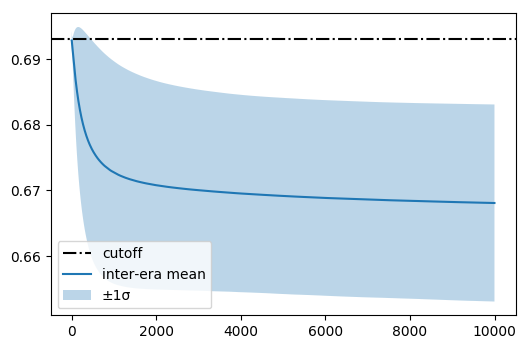

In [114]:
figure(dpi=100)
axhline(log_loss([1, 0], [0.5, 0.5]), linestyle='-.', color='k', label='cutoff')
plot(mus, label='inter-era mean')
fill_between(arange(len(mus)), array(mus)-array(sigs), array(mus)+array(sigs), alpha=0.3, label='±1σ')
legend(loc='lower left')

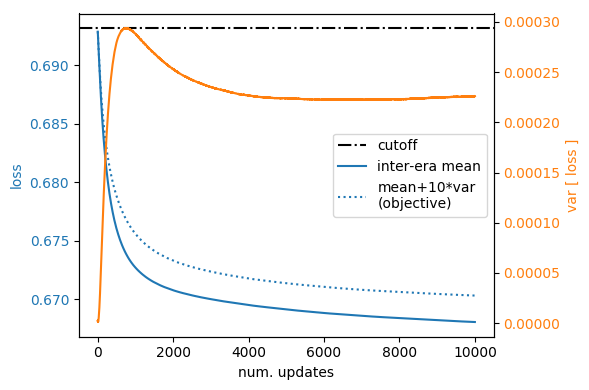

In [129]:
fig, ax1 = subplots(dpi=100)
ax1.axhline(log_loss([1, 0], [0.5, 0.5]), linestyle='-.', color='K', label='cutoff')
ax1.set_xlabel('num. updates')
color = 'C0'
ax1.set_ylabel('loss', color=color)
ax1.plot(mus, color=color, label='inter-era mean')
ax1.plot(losses, color=color, linestyle=':', label='mean+10*var\n(objective)')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'C1'
ax2.set_ylabel('var [ loss ]', color=color)
ax2.plot(array(sigs)**2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='best')
fig.tight_layout()

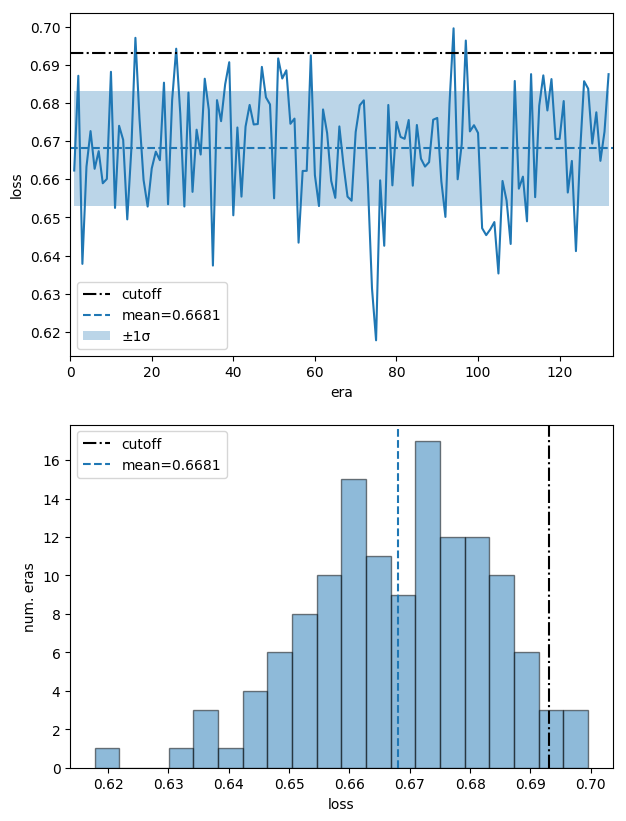

In [141]:
fig, (ax1, ax2) = subplots(2, 1, figsize=(7, 10), dpi=100)
ax1.plot(ueras, xents[-1])
ax1.axhline(log_loss([1, 0], [0.5, 0.5]), linestyle='-.', color='k', label='cutoff')
ax1.axhline(mean(xents[-1]), linestyle='--', color='C0', label='mean={:.4f}'.format(mean(xents[-1])))
ax1.fill_between(ueras, 
                 mean(xents[-1])-std(xents[-1]), 
                 mean(xents[-1])+std(xents[-1]), alpha=0.3, label='±1σ')
ax1.set_xlabel('era')
ax1.set_ylabel('loss')
ax1.set_xlim(ueras[0]-1, ueras[-1]+1)
ax1.legend()
ax2.hist(xents[-1], bins=20, facecolor='C0', alpha=0.5, edgecolor='K')
ax2.axvline(log_loss([1, 0], [0.5, 0.5]), linestyle='-.', color='k', label='cutoff')
ax2.axvline(mean(xents[-1]), linestyle='--', color='C0', 
            label='mean={:.4f}'.format(mean(xents[-1])))
ax2.set_xlabel('loss')
ax2.set_ylabel('num. eras')
ax2.legend()

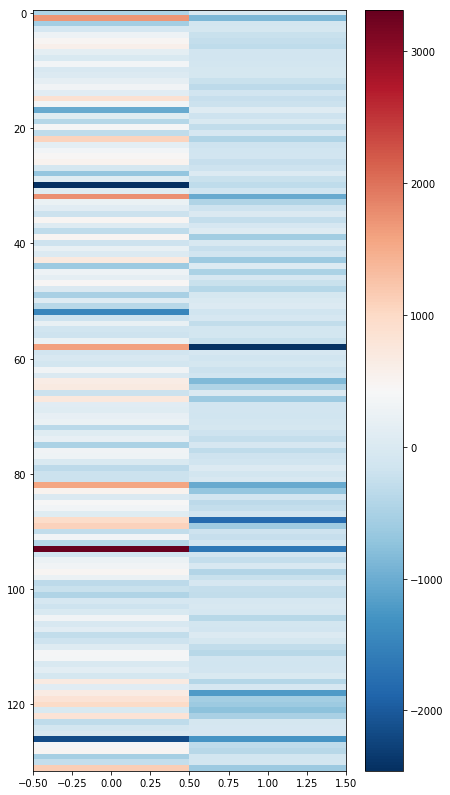

In [61]:
figure(figsize=(7, 14))
imshow(w_sol[:, 0], aspect='auto', cmap='RdBu_r')
colorbar()

In [24]:
logits_test = empty((K, len(X_test), len(Cs)))
for i in tqdm_notebook(range(K)):
    for j in range(len(Cs)):
        logits_test[i, :, j] = models[i, j].decision_function(X_test)

In [106]:
test_probs = predict_weighted_proba(logits_test, w_sol)

In [107]:
from predict import postprocess_results
results = postprocess_results(tourn_df['id'], test_output, target)
savetxt('/Volumes/4TB/numerai/119/predictions_{}_voting_gradientDescent_vw10.csv'.format(target), 
        results, delimiter=',', fmt='%s')